In [15]:
import os
import pickle

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [16]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])

## Stationarity test

In [17]:
statistics, pval, usedlag, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {usedlag} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {usedlag} {nobs}")

Data is stationary -12.704162687630872 1.0639878489320223e-23 49 25581.


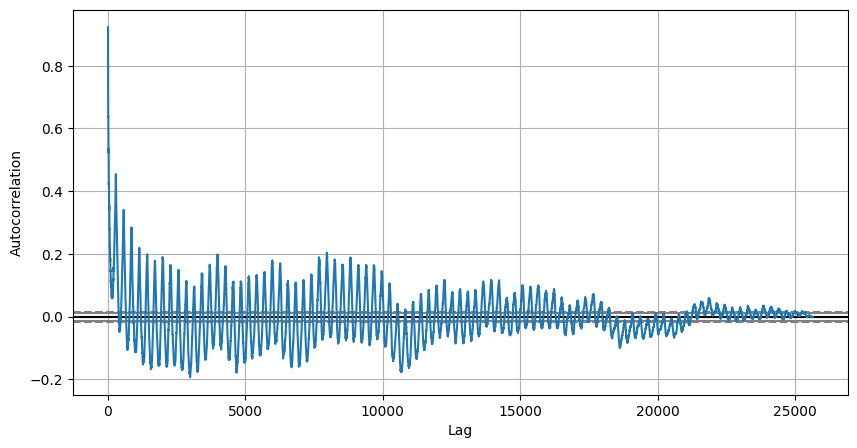

In [18]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(10, 5))
autocorrelation_plot(series.values, ax)
plt.show()

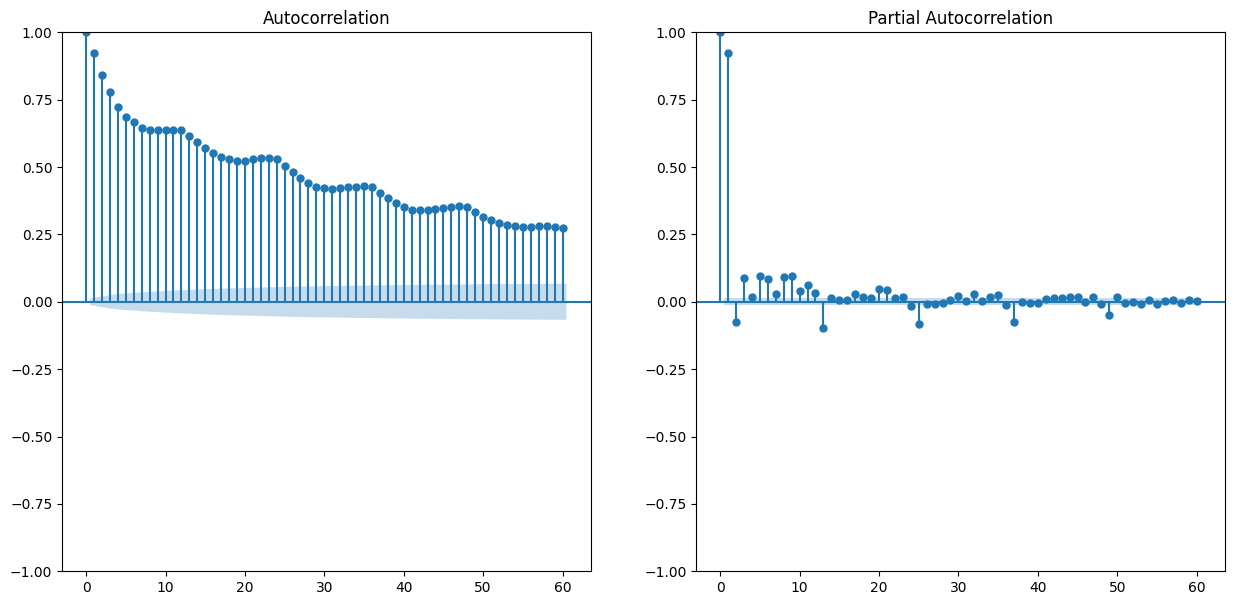

In [19]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[1])
plt.show()

In [22]:
X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
print(len(train))
print(len(test))

20504
5127


In [23]:
def absolute_error_statistics(original : np.array, predicted : np.array):
    assert len(original) == len(predicted)
    return np.absolute(original - predicted)

In [24]:
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

In [25]:
print(model_fit.params)

[60.41279792  0.88884785  0.1168448  78.73908056]


In [ ]:
#TODO: save params of the MA and AR and provide them in .fit(params  = <burn_in_model>.params)
model = ARIMA(train, order=(49, 1, 285))
model_fit = model.fit()

In [ ]:
model_fit.save('ARIMA.pkl')

In [ ]:
predicted = []

for t in range(test):
    prediction = model_fit.forecast(1)
    model_fit = model_fit.append([prediction], refit=False)

In [8]:
stats = []
error = []
for idx, order in enumerate(test_orders):
    history = [x for x in train]
    predictions = list()
    model = ARIMA(history, order=order)
    model_fit = model.fit()
    predictions = model_fit.forecast(len(test))
    # for t in tqdm(range(len(test))):
    #     model_fit = model.fit()
    #     output = model_fit.forecast()
    #     yhat = output[0]
    #     predictions.append(yhat)
    #     obs = test[t]
    #     history.append(obs)
    # rmse = sqrt(mean_squared_error(test, predictions))
    # print('Test RMSE: %.3f' % rmse)
    # error.append(rmse)
    # res = pd.DataFrame(absolute_error_statistics(np.array(test), np.array(predictions)))
    # res.to_csv(f"{dir}{idx}.csv")


ticks = [str(elem) for elem in test_orders]

plt.figure(figsize=(30,7))
plt.plot(ticks, error, color='r', label='rmse', marker='x')
plt.xticks(ticks)
plt.xlabel('Arima order')
plt.ylabel('RMSE')
plt.legend(loc='best')
plt.show()

KeyboardInterrupt: 

In [61]:
dataframes = {}

for idx, file in enumerate(os.listdir(dir)):
    full_file_name = dir + file
    df = pd.read_csv(full_file_name)
    dataframes[idx] = df[df.columns[1:]]['0'].values.tolist()

described = pd.DataFrame(dataframes)
described = described.describe()

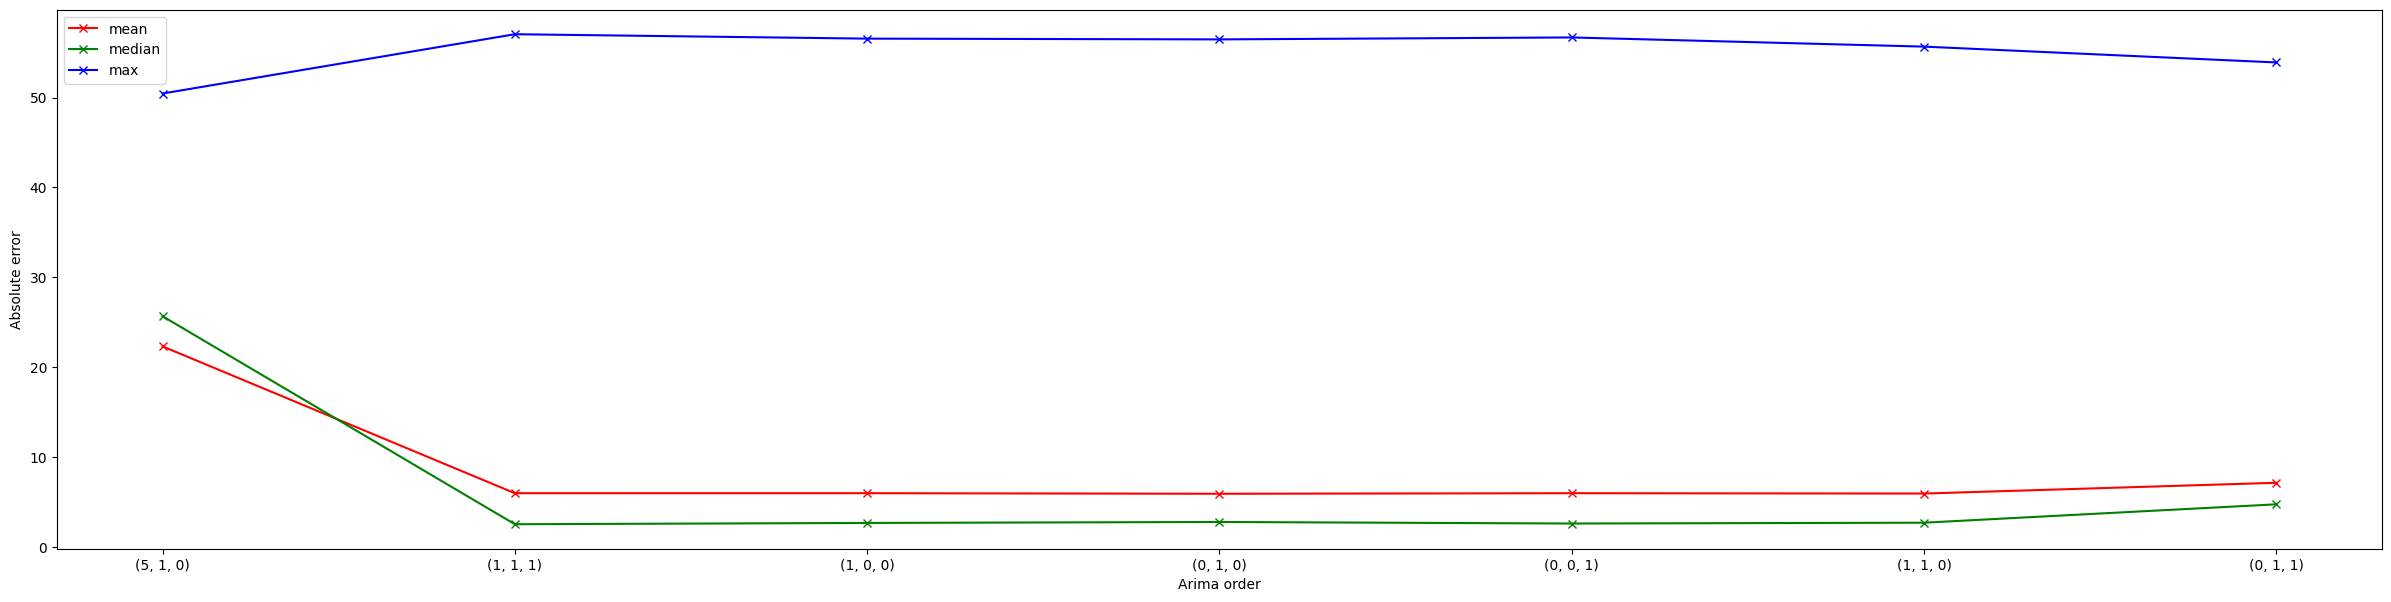

In [62]:
mean = []
fifty = []
max_error = []

for item in described.axes[1]:
    mean.append(described[item]['mean'])
    fifty.append(described[item]['50%'])
    max_error.append(described[item]['max'])

ticks = [str(elem) for elem in test_orders]

plt.figure(figsize=(30,7))
plt.plot(ticks, mean, color='r', label='mean', marker='x')
plt.plot(ticks, fifty, color='g', label='median', marker='x')
plt.plot(ticks, max_error, color='b', label='max', marker='x')
plt.xticks(ticks)
plt.xlabel('Arima order')
plt.ylabel('Absolute error')
plt.legend(loc='best')
plt.show()